In [1]:
import random
import networkx as nx
import os
import matplotlib.pyplot as plt

Successfully loaded graph with 11 nodes.


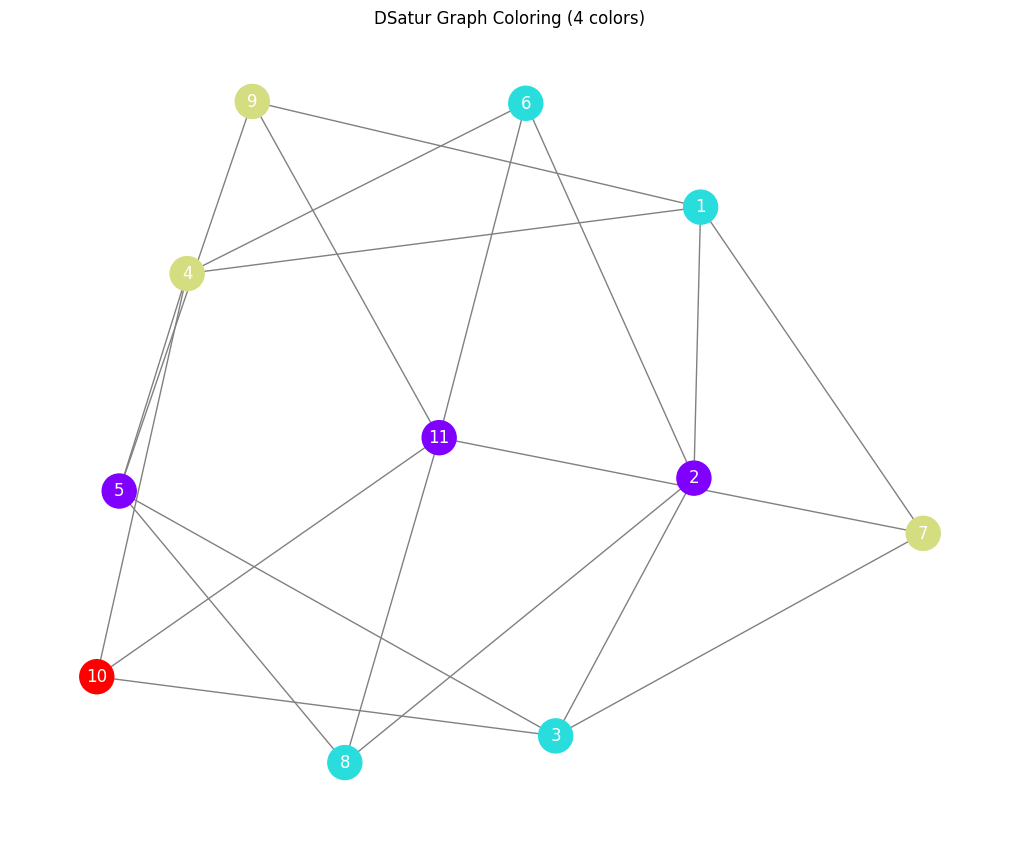

DSatur finished. Chromatic number found: 4
Node 11 -> Color 0
Node 6 -> Color 1
Node 2 -> Color 0
Node 1 -> Color 1
Node 7 -> Color 2


In [2]:
def read_col_file(file_path):
    """
    Parses a DIMACS .col file and returns a NetworkX graph.
    """
    G = nx.Graph()
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} not found.")

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('c'):
                continue
            
            parts = line.split()
            if parts[0] == 'p':
                # p edge [num_nodes] [num_edges]
                num_nodes = int(parts[2])
                G.add_nodes_from(range(1, num_nodes + 1))
            elif parts[0] == 'e':
                # e [node1] [node2]
                u, v = int(parts[1]), int(parts[2])
                G.add_edge(u, v)
                
    return G

def dsatur_coloring(G):
    """
    DSatur algorithm implementation.
    """
    colors = {}
    degrees = dict(G.degree())
    saturation_degrees = {node: 0 for node in G.nodes()}
    neighbor_colors = {node: set() for node in G.nodes()}
    uncolored_nodes = list(G.nodes())

    while uncolored_nodes:
        # Pick node with max saturation, then max degree
        best_node = max(
            uncolored_nodes, 
            key=lambda n: (saturation_degrees[n], degrees[n])
        )

        # Find lowest available color
        forbidden = neighbor_colors[best_node]
        color = 0
        while color in forbidden:
            color += 1
        
        colors[best_node] = color
        uncolored_nodes.remove(best_node)

        # Update neighbors
        for neighbor in G.neighbors(best_node):
            if neighbor not in colors:
                if color not in neighbor_colors[neighbor]:
                    neighbor_colors[neighbor].add(color)
                    saturation_degrees[neighbor] = len(neighbor_colors[neighbor])
    visualize_coloring(G, colors)
    return colors

def visualize_coloring(G, coloring):
    """
    Visualizes the graph with nodes colored based on the DSatur result.
    """
    # Create a layout (spring_layout is generally best for general graphs)
    pos = nx.spring_layout(G, seed=42) 
    
    # Map the coloring dictionary into a list ordered by G.nodes()
    # This ensures colors match the correct nodes during drawing
    node_colors = [coloring[node] for node in G.nodes()]
    
    plt.figure(figsize=(10, 8))
    
    # Draw the graph
    nx.draw(
        G, pos, 
        node_color=node_colors, 
        with_labels=True, 
        node_size=600, 
        cmap=plt.cm.rainbow,  # Uses a rainbow colormap for distinct colors
        font_color="white",
        edge_color="gray"
    )
    
    plt.title(f"DSatur Graph Coloring ({max(coloring.values())+1} colors)")
    plt.show()

# Example integration:
# coloring = dsatur_coloring(G)
# visualize_coloring(G, coloring)

# --- Main Execution ---
if __name__ == "__main__":
    # Replace 'my_graph.col' with your actual filename
    file_name = "myciel3.col" 
    
    try:
        graph = read_col_file(file_name)
        print(f"Successfully loaded graph with {graph.number_of_nodes()} nodes.")
        
        coloring_result = dsatur_coloring(graph)
        unique_colors = set(coloring_result.values())
        
        print(f"DSatur finished. Chromatic number found: {len(unique_colors)}")
        # Example: Print first 5 assignments
        for node in list(coloring_result.keys())[:5]:
            print(f"Node {node} -> Color {coloring_result[node]}")
            
    except Exception as e:
        print(f"Error: {e}")

In [4]:
# DIMACS .col file reader
def read_col_file(filename):
    edges = []
    num_vertices = 0

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('c'):
                continue
            if line.startswith('p'):
                parts = line.split()
                num_vertices = int(parts[2])
            elif line.startswith('e'):
                _, u, v = line.split()
                # Convert to 0-based indexing
                edges.append((int(u) - 1, int(v) - 1))

    return num_vertices, edges

In [61]:
# Parameters
POPULATION_SIZE = 1000
GENERATIONS = 100000
MUTATION_RATE = 0.06
ELITISM_SIZE = 5
TOURNAMENT_SIZE = 5

# Load graph

FILENAME = "myciel5.col"  # <-- your .col file
NUM_VERTICES, edges = read_col_file(FILENAME)

In [62]:
def initialize_population(num_colors):
    return [
        [random.randint(0, num_colors - 1) for _ in range(NUM_VERTICES)]
        for _ in range(POPULATION_SIZE)
    ]

def count_conflicts(individual):
    return sum(1 for u, v in edges if individual[u] == individual[v])

def fitness(individual):
    return 1 / (1 + count_conflicts(individual))

def tournament_selection(population):
    return max(
        random.sample(population, TOURNAMENT_SIZE),
        key=fitness
    )

def crossover(p1, p2):
    c1, c2 = [], []
    for g1, g2 in zip(p1, p2):
        if random.random() < 0.5:
            c1.append(g1)
            c2.append(g2)
        else:
            c1.append(g2)
            c2.append(g1)
    return c1, c2

def mutation(individual):
    for i in range(NUM_VERTICES):
        if random.random() < MUTATION_RATE:
            individual[i] = random.randint(0, NUM_COLORS - 1)
    return individual

In [68]:

# Genetic Algorithm
# You must choose k (upper bound)
NUM_COLORS = 6

def genetic_algorithm():

    print(f'K = {NUM_COLORS}')
    population = initialize_population(NUM_COLORS)

    for generation in range(GENERATIONS):
        new_population = []

        for _ in range(POPULATION_SIZE // 2):
            p1 = tournament_selection(population)
            p2 = tournament_selection(population)

            c1, c2 = crossover(p1, p2)
            c1 = mutation(c1)
            c2 = mutation(c2)

            new_population.extend([c1, c2])

        # Elitism
        population.sort(key=fitness, reverse=True)
        elites = population[:ELITISM_SIZE]
        new_population[:ELITISM_SIZE] = elites

        population = new_population

        best = max(population, key=fitness)
        conflicts = count_conflicts(best)

        if conflicts == 0:
            print(f"Valid coloring found at generation {generation}")
            print(f"Gen {generation}: best conflicts = {conflicts}")
            return best

        if generation % 50 == 0:
            print(f"Gen {generation}: best conflicts = {conflicts}")

        #return max(population, key=fitness)

In [69]:
solution = genetic_algorithm()

K = 6
Gen 0: best conflicts = 21
Valid coloring found at generation 31
Gen 31: best conflicts = 0


In [70]:
solution

[0,
 1,
 3,
 5,
 0,
 3,
 1,
 5,
 5,
 4,
 0,
 0,
 4,
 3,
 1,
 0,
 4,
 1,
 3,
 1,
 1,
 0,
 5,
 2,
 1,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 4,
 2,
 3,
 2,
 3,
 1,
 4,
 2,
 1,
 4,
 4,
 2,
 2,
 5,
 0]

In [52]:
print("Best coloring found:")
print(solution)
print("Conflicts:", count_conflicts(solution))

Best coloring found:
[4, 4, 1, 0, 4, 2, 5, 4, 2, 3, 1, 3, 0, 1, 2, 3, 3, 2, 0, 1, 2, 1, 4, 5, 3, 5, 0, 5, 4, 2, 5, 3, 5, 1, 3, 4, 5, 0, 5, 5, 2, 1, 5, 5, 1, 4, 0]
Conflicts: 20
